**References:**  

Data source
https://mrv.emsa.europa.eu/#public/emission-report

More information on criteria for craft
https://climate.ec.europa.eu/system/files/2017-06/20170517_guidance_cargo_en.pdf


In [1]:
import pandas as pd
import numpy as np
import re

### Data Integrity Check

In [2]:
from modules.analysis import MissingnessProfiler

In [3]:
data = pd.read_csv("./refined_data/clean_data.csv", low_memory = False)

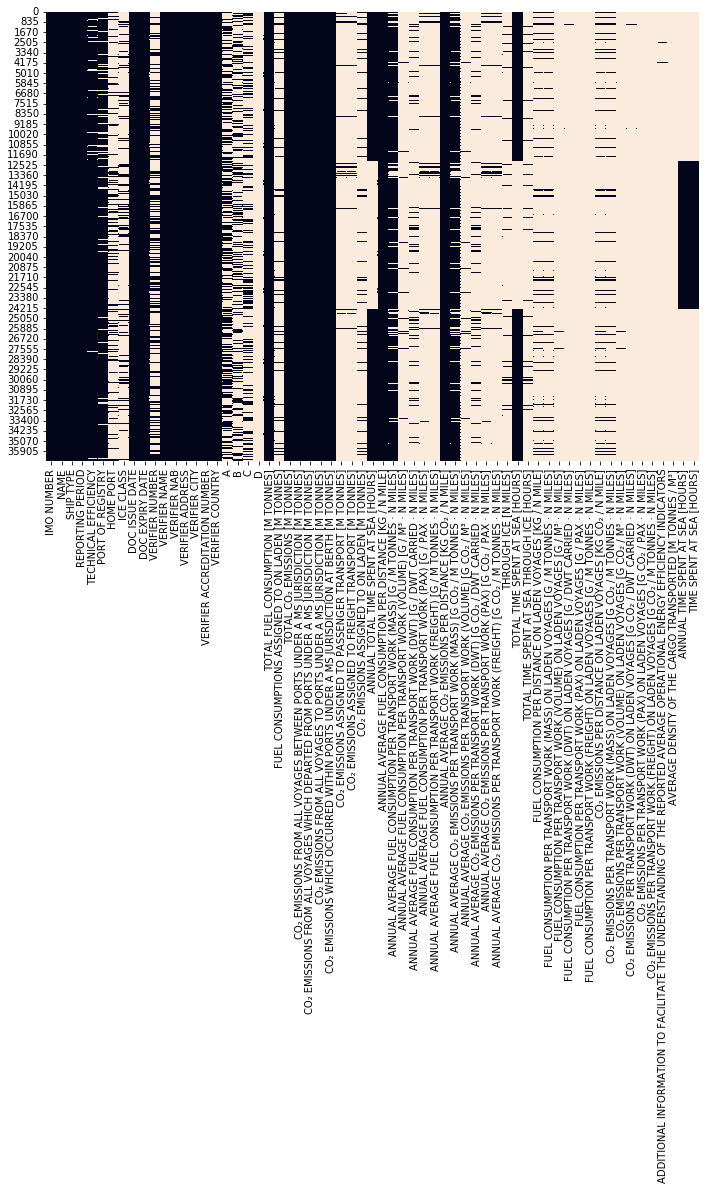

In [36]:
ma = MissingnessProfiler(data)
p = ma.plot_missingness()
display(p)

Some of the columns here, are extremely sparse (black present, white missing). We can also see above by this view, that the column labels for the time spent at sea and annual time spent as sea have different column headers (contiguous block missingness), and we can now include that step as part of our data cleaning, to align these features across dataset productions. 

Most of the columns with the higher degrees of missingness will not be useful for analysis at this time. Even if the business case would allow, there is more much in the cases to interpolate from. 

### How many ships of each type are there?

As expected, there are more than one occurrence of each ship in the dataset. These data do cover 3 years of declarations, after all. 

In [5]:
data.groupby('IMO NUMBER').count()['SHIP TYPE'].sort_values(ascending=False)

IMO NUMBER
9320128    3
9365398    3
9729271    3
9365269    3
9365257    3
          ..
9497830    1
9497414    1
9497335    1
9497323    1
9910088    1
Name: SHIP TYPE, Length: 16800, dtype: int64

In [6]:
data['SHIP TYPE'].unique()

array(['Passenger ship', 'Ro-pax ship', 'Other ship types', 'Ro-ro ship',
       'Gas carrier', 'Bulk carrier', 'General cargo ship',
       'Vehicle carrier', 'Chemical tanker', 'Container ship',
       'Refrigerated cargo carrier', 'Container/ro-ro cargo ship',
       'Oil tanker', 'Combination carrier', 'LNG carrier'], dtype=object)

In [37]:
# There are several records with the same IMO number (different port arrivals).
# We have to remove the duplicates and then count by ship type
df_type_tally = pd.DataFrame(data.drop_duplicates(subset='IMO NUMBER').groupby(['SHIP TYPE']).count()['A'].sort_values(ascending=False)).reset_index()
df_type_tally.columns = ['ship_type', 'count']

In [38]:
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
df_type_tally

,ship_type,count
0,Bulk carrier,3058
1,Oil tanker,991
2,General cargo ship,843
3,Container ship,788
4,Chemical tanker,584
5,Ro-pax ship,183
6,Gas carrier,165
7,Vehicle carrier,165
8,Ro-ro ship,149
9,LNG carrier,116


Text(0.5, 1.0, 'Frequency Distribution of Ship Type')

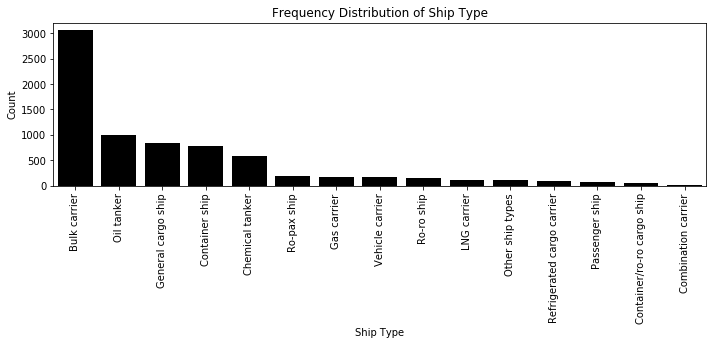

In [39]:
# Visualization of 
plt.rcParams['figure.figsize'] = 11.7, 3

sns.barplot(data = df_type_tally.sort_values('count', ascending = False), x = 'ship_type', y = 'count', color = 'black')
plt.xticks(rotation=90)
plt.xlabel("Ship Type")
plt.ylabel('Count')
plt.title('Frequency Distribution of Ship Type')

### How do the emissions profiles differ for different ship types?

Many of the data tyeps (columns) only have a small number of non-NaN values (< 5% of total records; as seen below), so for the purposes of this exercise, I will focus on the emissions data with several thousands of records. 

In [11]:
for c in data.columns:
    if 'EMISSIONS' in c:
        print(f"{c} .... {len(data[c].unique())}")

TOTAL CO₂ EMISSIONS [M TONNES] .... 35023
CO₂ EMISSIONS FROM ALL VOYAGES BETWEEN PORTS UNDER A MS JURISDICTION [M TONNES] .... 25710
CO₂ EMISSIONS FROM ALL VOYAGES WHICH DEPARTED FROM PORTS UNDER A MS JURISDICTION [M TONNES] .... 30854
CO₂ EMISSIONS FROM ALL VOYAGES TO PORTS UNDER A MS JURISDICTION [M TONNES] .... 30965
CO₂ EMISSIONS WHICH OCCURRED WITHIN PORTS UNDER A MS JURISDICTION AT BERTH [M TONNES] .... 26691
CO₂ EMISSIONS ASSIGNED TO PASSENGER TRANSPORT [M TONNES] .... 1165
CO₂ EMISSIONS ASSIGNED TO FREIGHT TRANSPORT [M TONNES] .... 1142
CO₂ EMISSIONS ASSIGNED TO ON LADEN [M TONNES] .... 3922
ANNUAL AVERAGE CO₂ EMISSIONS PER DISTANCE [KG CO₂ / N MILE] .... 25668
ANNUAL AVERAGE CO₂ EMISSIONS PER TRANSPORT WORK (MASS) [G CO₂ / M TONNES · N MILES] .... 7862
ANNUAL AVERAGE CO₂ EMISSIONS PER TRANSPORT WORK (VOLUME) [G CO₂ / M³ · N MILES] .... 724
ANNUAL AVERAGE CO₂ EMISSIONS PER TRANSPORT WORK (DWT) [G CO₂ / DWT CARRIED · N MILES] .... 2668
ANNUAL AVERAGE CO₂ EMISSIONS PER TRANSPORT 

In [12]:
from modules.dataviz import MRVDataviz

In [13]:
dataviz = MRVDataviz(data)

The distributions will be visualized as violin plots, so that we can better view the distribution of individual craft records (and across the 3 years). Rather than aggregate emissions values and show them as something like an average ship type emission, I would like to know the real distribution of each craft as they actually are because that distribution conveys more information about the individual data points and the population as a whole. 

This could also be easily displayed as a vertical scatter graph but I find violin plots to be a cleaner means of getting a first glimpse of these distributions.

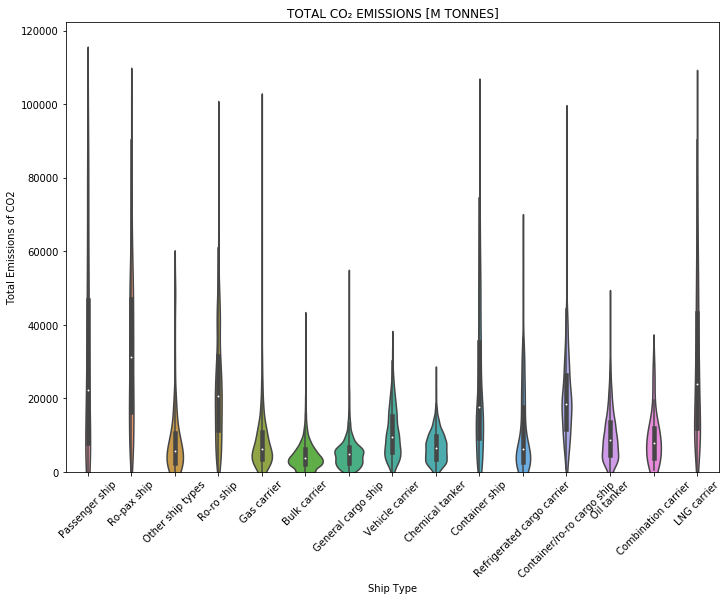

In [14]:
dataviz.total_emissions()

The ships with the the widest distribution, including the heighest levels of total emissions are: 
* Passenger ships
* Ro-pax ships
* Ro-ro ships
* Container ships
* Refridgerated cargo carriers 
* LNG carriers

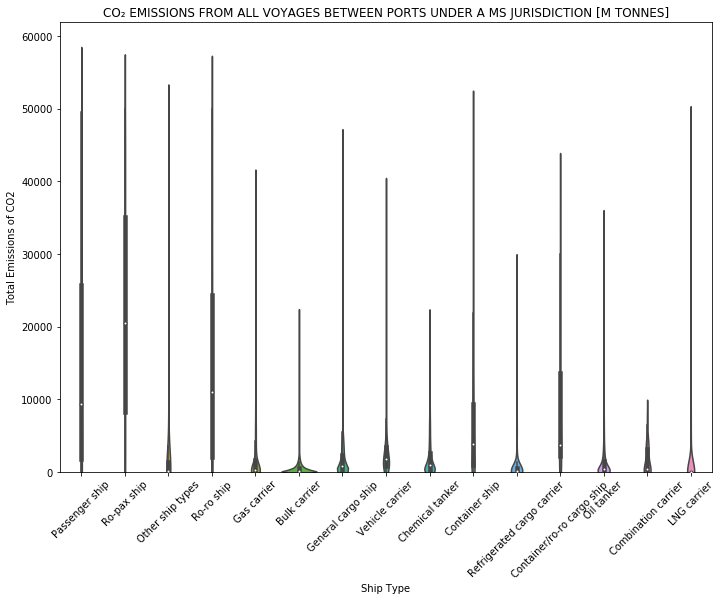

In [15]:
dataviz.between_msports_emissions()

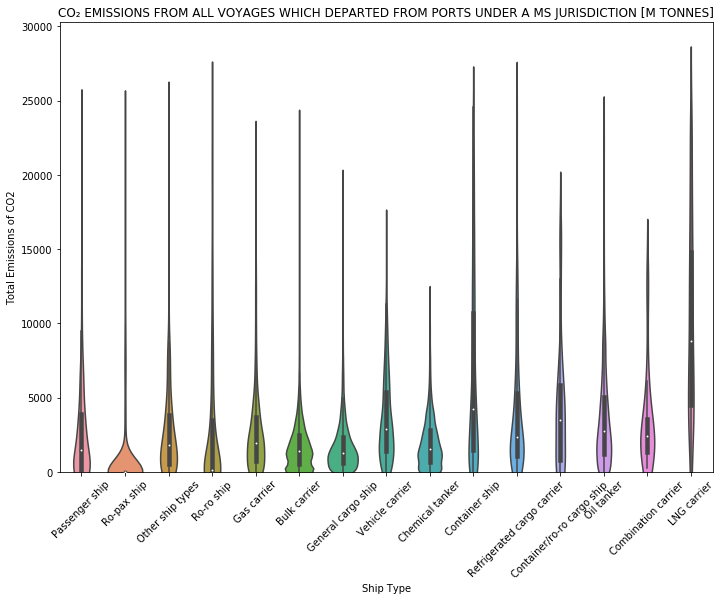

In [16]:
dataviz.departed_msports_emissions()

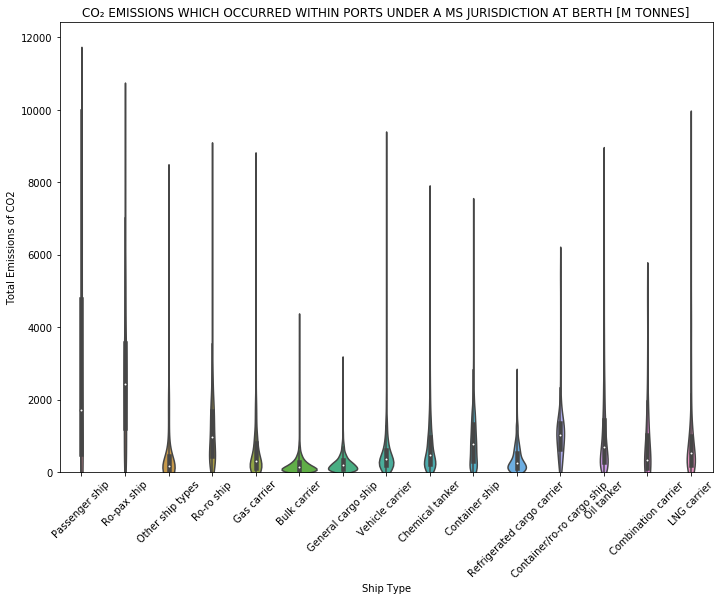

In [17]:
dataviz.within_msports_emissions()

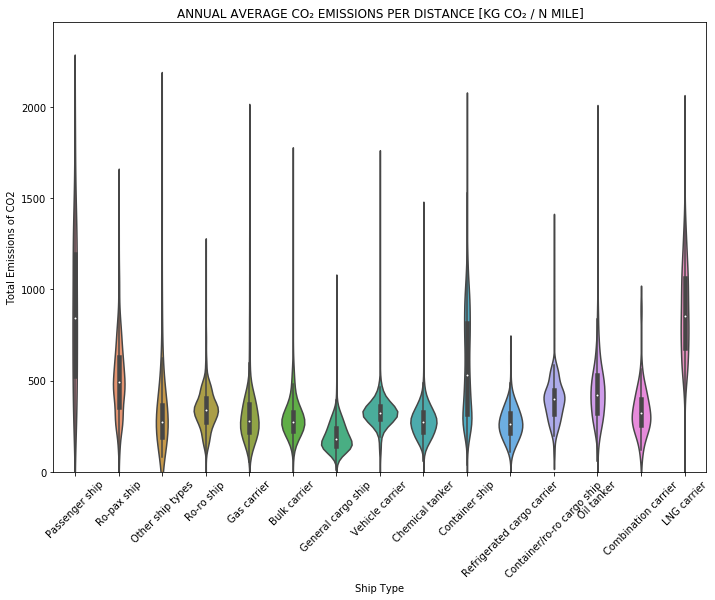

In [18]:
dataviz.annual_ave_emissions_per_distance()

In [19]:
df_emissions = data[['SHIP TYPE', 'TOTAL CO₂ EMISSIONS [M TONNES]']].copy()
df_emissions.columns = ['type', 'tot_emissions']

In [20]:
df_emissions

,type,tot_emissions
0,Passenger ship,20080.25
1,Passenger ship,25689.03
2,Ro-pax ship,6941.34
3,Passenger ship,19478.27
4,Other ship types,1724.63
...,...,...
36713,General cargo ship,1224.96
36714,General cargo ship,985.03
36715,General cargo ship,1032.14
36716,General cargo ship,581.94


### What is the relationship between ship Deadweight and emissions intensity?

In [21]:
df_deadweightemissions = data[["IMO NUMBER", "SHIP TYPE", "TOTAL CO₂ EMISSIONS [M TONNES]", "ANNUAL AVERAGE CO₂ EMISSIONS PER DISTANCE [KG CO₂ / N MILE]", "ANNUAL AVERAGE CO₂ EMISSIONS PER TRANSPORT WORK (DWT) [G CO₂ / DWT CARRIED · N MILES]"]].copy()
df_deadweightemissions.columns = ["imo", "type", "tot_emissions", "ave_emissions_per_distance", "emissions_per_transport_work"]

In [22]:
df_deadweightemissions["ave_emissions_per_distance"] = df_deadweightemissions.ave_emissions_per_distance.apply(lambda x: x if x != "" else "-999")

In [23]:
df_deadweightemissions["emissions_per_transport_work"] = df_deadweightemissions.emissions_per_transport_work.apply(lambda x: x if x != "" else "-999")

In [24]:
df_deadweightemissions['ave_emissions_per_distance'] = df_deadweightemissions.ave_emissions_per_distance.astype('float64')
df_deadweightemissions['emissions_per_transport_work'] = df_deadweightemissions.emissions_per_transport_work.astype('float64')

In [25]:
# Filtering for only records with data in both columns useful for the calculation
df_deadweightemissions = df_deadweightemissions.loc[df_deadweightemissions.ave_emissions_per_distance > 0]
df_deadweightemissions = df_deadweightemissions.loc[df_deadweightemissions.emissions_per_transport_work > 0]

In [26]:
# Calculation of deadweight based on unit conversion
df_deadweightemissions['dwt'] = df_deadweightemissions.apply(lambda x: x.ave_emissions_per_distance/x.emissions_per_transport_work * 1000, axis=1)

In [27]:
df_deadweightemissions.sort_values('dwt')

,imo,type,tot_emissions,ave_emissions_per_distance,emissions_per_transport_work,dwt
5626,9407665,Vehicle carrier,4517.43,206.25,4.517430e+09,4.565649e-05
25401,9177428,Vehicle carrier,25442.14,404.06,1.533860e+09,2.634269e-04
25446,9181560,Vehicle carrier,15402.48,397.72,6.398504e+08,6.215828e-04
30386,9437335,General cargo ship,2548.62,236.25,3.277973e+08,7.207198e-04
26574,9261011,General cargo ship,7265.92,242.42,1.319768e+07,1.836837e-02
...,...,...,...,...,...,...
4202,9338113,General cargo ship,4583.10,148.51,6.000000e-01,2.475167e+05
19699,9558581,General cargo ship,6011.55,145.53,2.600000e-01,5.597308e+05
24550,8708830,Vehicle carrier,9656.55,182.10,2.500000e-01,7.284000e+05
9140,9614830,General cargo ship,5218.96,120.03,1.200000e-01,1.000250e+06


Text(0, 0.5, 'Total Emissions of CO2')

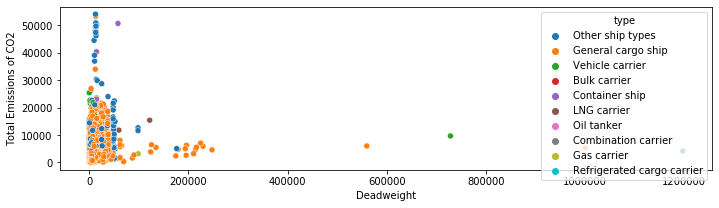

In [44]:
sns.scatterplot(data=df_deadweightemissions, x='dwt', y='tot_emissions', hue = 'type')
plt.rcParams['figure.figsize'] = 11.7,8.27
plt.xlabel("Deadweight")
plt.ylabel("Total Emissions of CO2")

The relationship between deadweight and total emissions is semi-linear with an extremely high slope. In other words, a small increase in deadweight results in a very large increase in total C02 emissions.

Let's filter on the bottom left of the graph (smaller deadweight craft) to see the breakdown more clearly.

Text(0, 0.5, 'Total Emissions of CO2')

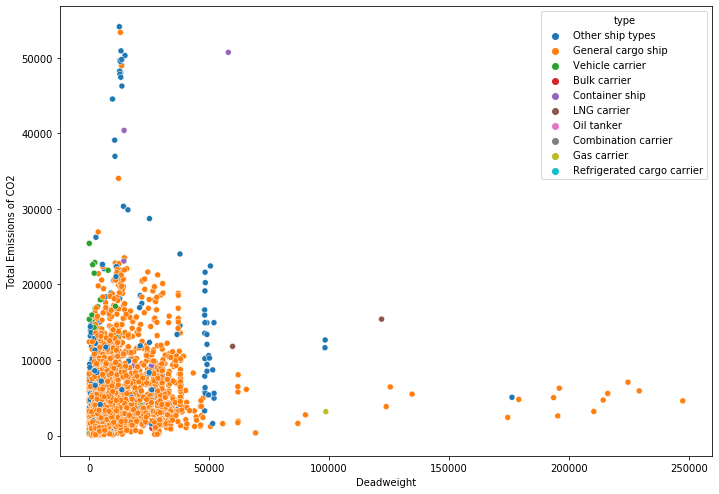

In [45]:
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

# figure size in inches
plt.rcParams['figure.figsize'] = 11.7,8.27

# Removing the outliers to get a better view of main data
sns.scatterplot(data=df_deadweightemissions.loc[df_deadweightemissions.dwt < 500000], x='dwt', y='tot_emissions', hue = 'type')
plt.xlabel("Deadweight")
plt.ylabel("Total Emissions of CO2")

Interestingly, there appears to be a class of general cargo ship for which the increase of deadweight has a minor bearing on the total CO2 emissions (deadweight 50000+).

Text(-8.699999999999996, 0.5, 'Total Emissions of CO2')

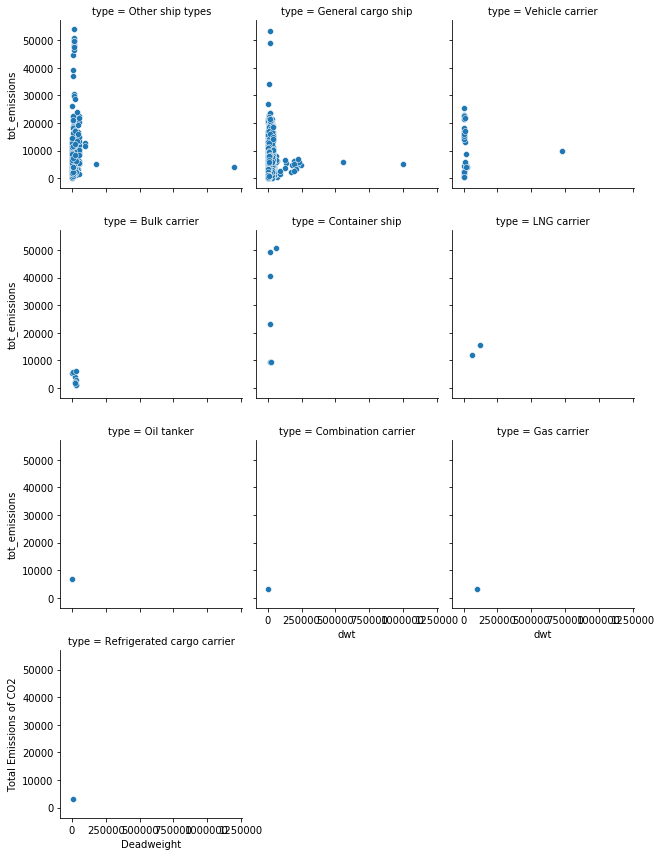

In [46]:
g = sns.FacetGrid(df_deadweightemissions, col="type", col_wrap=3)
g.map(sns.scatterplot, "dwt", "tot_emissions")
plt.xlabel("Deadweight")
plt.ylabel("Total Emissions of CO2")

### How many miles did each vessel in the database travel? 

* distance: d (mile)  
* total fuel consumption: C (m tons)  
* annual average fuel consumption per distance: R (kg/mile)  

Using a formula for calculating distance based on total fuel and average fuel efficiency while converting units
1000 is for kg to metric ton conversion.  
d = 1000*C/R

In [31]:
df_fuel = data[["IMO NUMBER", "TOTAL FUEL CONSUMPTION [M TONNES]", "ANNUAL AVERAGE FUEL CONSUMPTION PER DISTANCE [KG / N MILE]"]].copy()
df_fuel.columns = ["imo", "total_fuel_consumption", "fuel_consumption"]
df_fuel

,imo,total_fuel_consumption,fuel_consumption
0,5383304,6307.75,139.07
1,6417097,8125.56,143.81
2,6511128,2205.37,54.43
3,6602898,6151.40,120.93
4,6703343,549.00,63.46
...,...,...,...
36713,9873101,390.77,48.63
36714,9873113,314.92,33.73
36715,9873125,330.00,38.03
36716,9888792,185.88,36.69


In [32]:
df_fuel['fuel_consumption'] = df_fuel.fuel_consumption.astype('float64')

In [33]:
df_fuel.dtypes

imo                         int64
total_fuel_consumption    float64
fuel_consumption          float64
dtype: object

In [34]:
# Calculate the distance and filter out the records with the -999 imputation (thus making the calculation no good)
# This will make record-wise calculations of the distance
df_fuel["distance"] = df_fuel.apply(lambda x: x.total_fuel_consumption *1000/x.fuel_consumption, axis=1)
df_fuel.loc[df_fuel.fuel_consumption > 0].sort_values('distance', ascending = False)

# Now we need to sum over the IMO to find out what the total distance for all records is for each ship.
df_fuel_agg = df_fuel[['imo', 'distance']].groupby('imo').agg(['sum']).reset_index()
df_fuel_agg.columns = ['imo', 'distance']

In [35]:
df_fuel_agg.sort_values('distance', ascending=False).loc[df_fuel_agg.distance > 0]

,imo,distance
5125,9336268,438276.704711
4594,9319466,432034.001598
4592,9319442,424610.446309
1635,9198927,424336.376845
5552,9351505,424292.468874
...,...,...
2052,9225043,189.999793
1243,9166211,179.003415
9145,9485796,175.784753
1576,9194878,115.001938


Interestingly (and probably not surprisingly), according to **[Marine Traffic](https://www.marinetraffic.com/)** most of the highest mileage ships seem to be RO-RO/passenger ships with similar names (e.g. FINNSTAR, FINNMAID).

These numbers seem reasonable, since the average speed of those craft is 20 knot, which covers ~500 miles in a day, ~180,000 miles in a year, and ~500,000 miles in 3 years. 

## Next Steps

If given more time and if these approaches proved useful to the business, I would carry out the following steps to optimize the pipeline

* Automate collection of data into raw data repo (something like S3)
* More cleaning of additional columns (e.g. dtype casting and missingness handling for columns that I did not use in this analysis)
* Implement a database where deduplicated data from the loader would be outer joined with the database data(by something like IMO and date/time collected) to prevent duplication on the INSERT INTO statement.
* Some of the cleaning operations I would probably actually do in the database or column store itself, since this is often much faster and more scalable. 
* More error handling and type checking
* Enrich the data from outside sources (e.g. information on ships from sources like MarineTraffic) using things like webscrapers, other public data, and API calls. These could then be resolved the the craft in these MRV data by IMO number and could be used to verify and check some of the uncertain details our analysis (like the deadweight calculation).
